## Step 1. 데이터 수집하기

In [1]:
import os
import re
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings(action='ignore') 



In [2]:
file_path = os.getenv("HOME") + "/aiffel/aiffel_quest/mini_quest_240325/data/"

chat_data = pd.read_csv(file_path + "ChatbotData.csv")
chat_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
chat_data.tail()

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


## Step 2. 데이터 전처리하기
- 영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한<br>전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [8]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    re.sub(r"([?.!,])", r" \1 ", sentence)
#     sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #
#     sentence = re.sub(r'[" "]+', " ", sentence) 
#     sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence) #  ^a-zA-Z가-힣?.!,]+
    sentence = sentence.strip()
    return sentence

def load_conversations():
    inputs, outputs = [], []
    for i in range(len(chat_data) - 1):
        inputs.append(preprocess_sentence(chat_data.iloc[i]['Q']))
        outputs.append(preprocess_sentence(chat_data.iloc[i]['A']))
    return inputs, outputs


데이터 안에 불필요한 영어가 없다고 판단이 되어 <br>
특수문자만 전처리 하기로 결정

In [9]:
questions, answers = load_conversations()

# 전체 샘플 수와 특정 샘플의 내용을 출력
total_samples = len(questions)
sample_index = 3422
sample_question = questions[sample_index]
sample_answer = answers[sample_index]

total_samples, sample_question, sample_answer

(11822, '왜 공부해야하는지 모르겠어', '미래의 배우자가 달라져요.')

In [10]:
print('전체 샘플 수: ', len(questions))
print('전체 샘플 수: ', len(answers))

전체 샘플 수:  11822
전체 샘플 수:  11822


In [11]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


## Step 3. SubwordTextEncoder 사용하기
- 한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다.<br> 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용

In [12]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [13]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]


In [14]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8169]
END_TOKEN의 번호 : [8170]


In [15]:
# 시작 토큰과 종료 토큰을 고려햐여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8171


In [16]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5758, 607, 2490, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7509, 5, 6272, 95, 7959]


In [17]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요.


In [18]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 25 # 40
print(MAX_LENGTH)

25


학습 속도를 좀 올리기 위해 MAX_LENGH를 줄였다.<br>
이것도 정확도에 영향을 조금은 끼칠거라 생각이 든다.

In [19]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [20]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :', (VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))


단어장의 크기 : 8171
필터링 후의 질문 샘플 개수: 11816
필터링 후의 답변 샘플 개수: 11816


In [21]:
# 교사 강요 사용

BATCH_SIZE = 64
BUFFER_SIZE = 5000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기
- 실습 내용을 참고하여 트랜스포머 모델을 구현

In [22]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [23]:
# 패드 마스킹 
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [24]:
# 록 어헤드 마스킹 구현
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [25]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [26]:
# 멀티 헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [27]:
# 두개의 서브 층을 가지는 하나의 인코더 층을 구현
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [28]:
# 인코더 층을 쌓아 인코더 만들기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [29]:
# 디코더의 세 개의 서브층을 내부적으로 구현
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


In [30]:
# 디코더 층을 쌓아 디코더 만들기

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [31]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [32]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4
D_MODEL = 1024
NUM_HEADS = 8
UNITS = 2048
DROPOUT = 0.5

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 1024)   41966592    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

조금이라도 성능을 높이기 위해 UM_LAYERS, 
D_MODEL,
NUM_HEADS,
UNITS 의 값들을 올려가면서 진행을 했다.


In [33]:
# 손실함수
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [34]:
# 커스텀 된 학습률
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

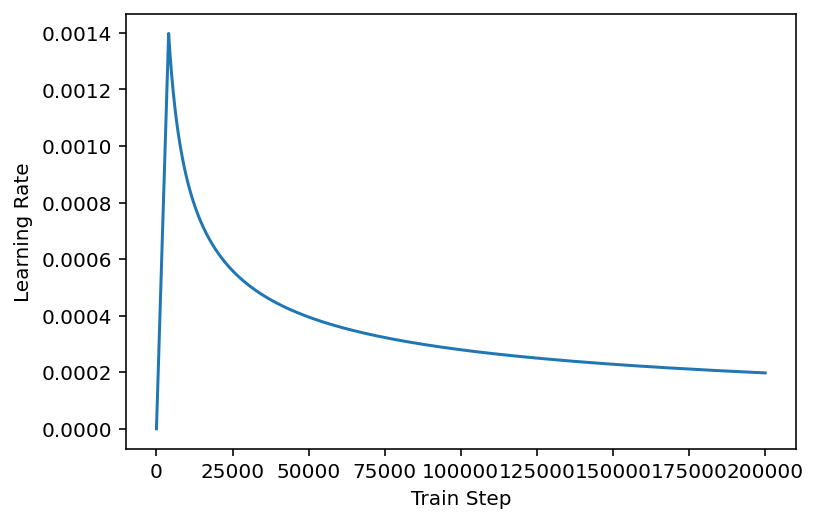

In [35]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [36]:
from tensorflow.keras import callbacks

learning_rate = CustomSchedule(D_MODEL)

check_point_cb = callbacks.ModelCheckpoint('chatbot.h5', save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=3, monitor='val_loss',
                                           restore_best_weights=True)


optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [37]:
EPOCHS = 1000 # 70?
history = model.fit(dataset, epochs=EPOCHS, callbacks=[check_point_cb, early_stopping_cb],verbose=1)

Epoch 1/1000
185/185 [==============================] - 67s 303ms/step - loss: 2.1113 - accuracy: 0.0372


Epoch 2/1000
185/185 [==============================] - 59s 321ms/step - loss: 1.7297 - accuracy: 0.0761


Epoch 3/1000
185/185 [==============================] - 59s 318ms/step - loss: 1.6302 - accuracy: 0.0814


Epoch 4/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.5811 - accuracy: 0.0819


Epoch 5/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.5463 - accuracy: 0.0829


Epoch 6/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.5176 - accuracy: 0.0842


Epoch 7/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.4910 - accuracy: 0.0856


Epoch 8/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.4670 - accuracy: 0.0865


Epoch 9/1000
185/185 [==============================] - 59s 318ms/step - loss: 1.4433 - accuracy: 0.0882


Epoch 10/1000
185/185 [==============================] - 59s 318ms/step - loss: 1.4221 - accuracy: 0.0896


Epoch 11/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.4026 - accuracy: 0.0905


Epoch 12/1000
185/185 [==============================] - 59s 318ms/step - loss: 1.3766 - accuracy: 0.0914


Epoch 13/1000
185/185 [==============================] - 59s 318ms/step - loss: 1.3551 - accuracy: 0.0921


Epoch 14/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.3332 - accuracy: 0.0930


Epoch 15/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.3117 - accuracy: 0.0937


Epoch 16/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.2925 - accuracy: 0.0944


Epoch 17/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.2735 - accuracy: 0.0950


Epoch 18/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.2526 - accuracy: 0.0959


Epoch 19/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.2350 - accuracy: 0.0967


Epoch 20/1000
185/185 [==============================] - 59s 319ms/step - loss: 1.2161 - accuracy: 0.0974


Epoch 21/1000
185/185 [==============================] - 59s 318ms/step - loss: 1.1987 - accuracy: 0.0980


Epoch 22/1000
185/185 [==============================] - 59s 318ms/step - loss: 1.1765 - accuracy: 0.0991


Epoch 23/1000
185/185 [==============================] - 59s 317ms/step - loss: 1.1574 - accuracy: 0.1002


Epoch 24/1000
185/185 [==============================] - 59s 318ms/step - loss: 1.1305 - accuracy: 0.1018


Epoch 25/1000
185/185 [==============================] - 59s 318ms/step - loss: 1.1049 - accuracy: 0.1031


Epoch 26/1000
185/185 [==============================] - 59s 317ms/step - loss: 1.0798 - accuracy: 0.1048


Epoch 27/1000
185/185 [==============================] - 59s 317ms/step - loss: 1.0565 - accuracy: 0.1062


Epoch 28/1000
185/185 [==============================] - 59s 317ms/step - loss: 1.0323 - accuracy: 0.1077


Epoch 29/1000
185/185 [==============================] - 59s 317ms/step - loss: 1.0105 - accuracy: 0.1097


Epoch 30/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.9880 - accuracy: 0.1116


Epoch 31/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.9720 - accuracy: 0.1124


Epoch 32/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.9478 - accuracy: 0.1144


Epoch 33/1000
185/185 [==============================] - 59s 319ms/step - loss: 0.9238 - accuracy: 0.1171


Epoch 34/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.9051 - accuracy: 0.1191


Epoch 35/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.8895 - accuracy: 0.1211


Epoch 36/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.8727 - accuracy: 0.1225


Epoch 37/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.8508 - accuracy: 0.1249


Epoch 38/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.8348 - accuracy: 0.1271


Epoch 39/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.8195 - accuracy: 0.1297


Epoch 40/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.8035 - accuracy: 0.1312


Epoch 41/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.7907 - accuracy: 0.1328


Epoch 42/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.7755 - accuracy: 0.1350


Epoch 43/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.7586 - accuracy: 0.1375


Epoch 44/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.7468 - accuracy: 0.1394


Epoch 45/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.7416 - accuracy: 0.1395


Epoch 46/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.7256 - accuracy: 0.1425


Epoch 47/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.7152 - accuracy: 0.1443


Epoch 48/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.7047 - accuracy: 0.1458


Epoch 49/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.6928 - accuracy: 0.1481


Epoch 50/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.6794 - accuracy: 0.1500


Epoch 51/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.6725 - accuracy: 0.1515


Epoch 52/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.6625 - accuracy: 0.1531


Epoch 53/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.6565 - accuracy: 0.1540


Epoch 54/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.6460 - accuracy: 0.1560


Epoch 55/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.6406 - accuracy: 0.1568


Epoch 56/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.6348 - accuracy: 0.1574


Epoch 57/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.6251 - accuracy: 0.1593


Epoch 58/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.6183 - accuracy: 0.1607


Epoch 59/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.6083 - accuracy: 0.1623


Epoch 60/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.6002 - accuracy: 0.1639


Epoch 61/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.5996 - accuracy: 0.1640


Epoch 62/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5949 - accuracy: 0.1653


Epoch 63/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5811 - accuracy: 0.1683


Epoch 64/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5803 - accuracy: 0.1679


Epoch 65/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.5745 - accuracy: 0.1692


Epoch 66/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5685 - accuracy: 0.1708


Epoch 67/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5643 - accuracy: 0.1712


Epoch 68/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5611 - accuracy: 0.1719


Epoch 69/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5580 - accuracy: 0.1727


Epoch 70/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5524 - accuracy: 0.1735


Epoch 71/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.5465 - accuracy: 0.1749


Epoch 72/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5420 - accuracy: 0.1763


Epoch 73/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.5377 - accuracy: 0.1764


Epoch 74/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5374 - accuracy: 0.1769


Epoch 75/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5293 - accuracy: 0.1785


Epoch 76/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5260 - accuracy: 0.1791


Epoch 77/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5176 - accuracy: 0.1807


Epoch 78/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5169 - accuracy: 0.1811


Epoch 79/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5128 - accuracy: 0.1815


Epoch 80/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5143 - accuracy: 0.1813


Epoch 81/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.5078 - accuracy: 0.1828


Epoch 82/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5064 - accuracy: 0.1830


Epoch 83/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.5017 - accuracy: 0.1837


Epoch 84/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.5014 - accuracy: 0.1840


Epoch 85/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4936 - accuracy: 0.1858


Epoch 86/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4919 - accuracy: 0.1860


Epoch 87/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4926 - accuracy: 0.1862


Epoch 88/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4869 - accuracy: 0.1872


Epoch 89/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.4852 - accuracy: 0.1875


Epoch 90/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4826 - accuracy: 0.1884


Epoch 91/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4797 - accuracy: 0.1889


Epoch 92/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.4779 - accuracy: 0.1890


Epoch 93/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4734 - accuracy: 0.1902


Epoch 94/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.4708 - accuracy: 0.1909


Epoch 95/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4735 - accuracy: 0.1903


Epoch 96/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4691 - accuracy: 0.1911


Epoch 97/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4700 - accuracy: 0.1908


Epoch 98/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4641 - accuracy: 0.1921


Epoch 99/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4613 - accuracy: 0.1925


Epoch 100/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.4562 - accuracy: 0.1938


Epoch 101/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4549 - accuracy: 0.1943


Epoch 102/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4534 - accuracy: 0.1947


Epoch 103/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4543 - accuracy: 0.1943


Epoch 104/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4516 - accuracy: 0.1948


Epoch 105/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4519 - accuracy: 0.1945


Epoch 106/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4488 - accuracy: 0.1954


Epoch 107/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4486 - accuracy: 0.1959


Epoch 108/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4436 - accuracy: 0.1969


Epoch 109/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4421 - accuracy: 0.1969


Epoch 110/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.4408 - accuracy: 0.1974


Epoch 111/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.4378 - accuracy: 0.1978


Epoch 112/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4369 - accuracy: 0.1977


Epoch 113/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4383 - accuracy: 0.1978


Epoch 114/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4356 - accuracy: 0.1985


Epoch 115/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.4336 - accuracy: 0.1990


Epoch 116/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4292 - accuracy: 0.2000


Epoch 117/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4298 - accuracy: 0.1994


Epoch 118/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4297 - accuracy: 0.1999


Epoch 119/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.4331 - accuracy: 0.1990


Epoch 120/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4286 - accuracy: 0.1999


Epoch 121/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4232 - accuracy: 0.2012


Epoch 122/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.4212 - accuracy: 0.2016


Epoch 123/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4215 - accuracy: 0.2018


Epoch 124/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4189 - accuracy: 0.2024


Epoch 125/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4194 - accuracy: 0.2021


Epoch 126/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.4172 - accuracy: 0.2021


Epoch 127/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4174 - accuracy: 0.2026


Epoch 128/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4165 - accuracy: 0.2026


Epoch 129/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.4155 - accuracy: 0.2031


Epoch 130/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.4178 - accuracy: 0.2029


Epoch 131/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4101 - accuracy: 0.2038


Epoch 132/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4115 - accuracy: 0.2040


Epoch 133/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.4120 - accuracy: 0.2039


Epoch 134/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4119 - accuracy: 0.2039


Epoch 135/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4080 - accuracy: 0.2046


Epoch 136/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4076 - accuracy: 0.2047


Epoch 137/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4059 - accuracy: 0.2054


Epoch 138/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4056 - accuracy: 0.2052


Epoch 139/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.4040 - accuracy: 0.2057


Epoch 140/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.4023 - accuracy: 0.2059


Epoch 141/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4016 - accuracy: 0.2057


Epoch 142/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.4020 - accuracy: 0.2056


Epoch 143/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3979 - accuracy: 0.2068


Epoch 144/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3982 - accuracy: 0.2072


Epoch 145/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3981 - accuracy: 0.2067


Epoch 146/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3957 - accuracy: 0.2073


Epoch 147/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3959 - accuracy: 0.2075


Epoch 148/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3956 - accuracy: 0.2075


Epoch 149/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3928 - accuracy: 0.2081


Epoch 150/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3937 - accuracy: 0.2075


Epoch 151/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3926 - accuracy: 0.2077


Epoch 152/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3924 - accuracy: 0.2081


Epoch 153/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3911 - accuracy: 0.2085


Epoch 154/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3891 - accuracy: 0.2089


Epoch 155/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3882 - accuracy: 0.2091


Epoch 156/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3895 - accuracy: 0.2088


Epoch 157/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3850 - accuracy: 0.2097


Epoch 158/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3869 - accuracy: 0.2095


Epoch 159/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3861 - accuracy: 0.2093


Epoch 160/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3851 - accuracy: 0.2097


Epoch 161/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3853 - accuracy: 0.2096


Epoch 162/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3839 - accuracy: 0.2101


Epoch 163/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3806 - accuracy: 0.2106


Epoch 164/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3812 - accuracy: 0.2106


Epoch 165/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3810 - accuracy: 0.2105


Epoch 166/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3815 - accuracy: 0.2102


Epoch 167/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3796 - accuracy: 0.2111


Epoch 168/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3799 - accuracy: 0.2107


Epoch 169/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3800 - accuracy: 0.2110


Epoch 170/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3751 - accuracy: 0.2118


Epoch 171/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3753 - accuracy: 0.2116


Epoch 172/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3760 - accuracy: 0.2115


Epoch 173/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3759 - accuracy: 0.2115


Epoch 174/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3783 - accuracy: 0.2110


Epoch 175/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3790 - accuracy: 0.2112


Epoch 176/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3736 - accuracy: 0.2122


Epoch 177/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3761 - accuracy: 0.2117


Epoch 178/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3755 - accuracy: 0.2118


Epoch 179/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3715 - accuracy: 0.2126


Epoch 180/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3721 - accuracy: 0.2125


Epoch 181/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3734 - accuracy: 0.2124


Epoch 182/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3701 - accuracy: 0.2131


Epoch 183/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3684 - accuracy: 0.2131


Epoch 184/1000
185/185 [==============================] - 59s 319ms/step - loss: 0.3676 - accuracy: 0.2133


Epoch 185/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3700 - accuracy: 0.2133


Epoch 186/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3707 - accuracy: 0.2131


Epoch 187/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3669 - accuracy: 0.2136


Epoch 188/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3670 - accuracy: 0.2135


Epoch 189/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3668 - accuracy: 0.2137


Epoch 190/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3652 - accuracy: 0.2142


Epoch 191/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3631 - accuracy: 0.2140


Epoch 192/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3635 - accuracy: 0.2142


Epoch 193/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3649 - accuracy: 0.2145


Epoch 194/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3621 - accuracy: 0.2147


Epoch 195/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3649 - accuracy: 0.2140


Epoch 196/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3589 - accuracy: 0.2152


Epoch 197/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3600 - accuracy: 0.2154


Epoch 198/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3610 - accuracy: 0.2149


Epoch 199/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3579 - accuracy: 0.2156


Epoch 200/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3607 - accuracy: 0.2149


Epoch 201/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3611 - accuracy: 0.2149


Epoch 202/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3603 - accuracy: 0.2149


Epoch 203/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3591 - accuracy: 0.2155


Epoch 204/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.3589 - accuracy: 0.2154


Epoch 205/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3595 - accuracy: 0.2155


Epoch 206/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3576 - accuracy: 0.2156


Epoch 207/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.3575 - accuracy: 0.2159


Epoch 208/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3564 - accuracy: 0.2159


Epoch 209/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3583 - accuracy: 0.2154


Epoch 210/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3542 - accuracy: 0.2166


Epoch 211/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3561 - accuracy: 0.2159


Epoch 212/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3561 - accuracy: 0.2159


Epoch 213/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3544 - accuracy: 0.2164


Epoch 214/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3532 - accuracy: 0.2165


Epoch 215/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3514 - accuracy: 0.2170


Epoch 216/1000
185/185 [==============================] - 58s 313ms/step - loss: 0.3502 - accuracy: 0.2172


Epoch 217/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3537 - accuracy: 0.2166


Epoch 218/1000
185/185 [==============================] - 58s 313ms/step - loss: 0.3506 - accuracy: 0.2171


Epoch 219/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3504 - accuracy: 0.2171


Epoch 220/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3499 - accuracy: 0.2173


Epoch 221/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3490 - accuracy: 0.2177


Epoch 222/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3500 - accuracy: 0.2173


Epoch 223/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3502 - accuracy: 0.2170


Epoch 224/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3455 - accuracy: 0.2183


Epoch 225/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3491 - accuracy: 0.2176


Epoch 226/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3470 - accuracy: 0.2177


Epoch 227/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3470 - accuracy: 0.2179


Epoch 228/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3477 - accuracy: 0.2176


Epoch 229/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3449 - accuracy: 0.2179


Epoch 230/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3435 - accuracy: 0.2182


Epoch 231/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3441 - accuracy: 0.2189


Epoch 232/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3442 - accuracy: 0.2182


Epoch 233/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3430 - accuracy: 0.2187


Epoch 234/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3445 - accuracy: 0.2184


Epoch 235/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3434 - accuracy: 0.2188


Epoch 236/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3441 - accuracy: 0.2183


Epoch 237/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3439 - accuracy: 0.2189


Epoch 238/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3438 - accuracy: 0.2187


Epoch 239/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3437 - accuracy: 0.2187


Epoch 240/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3407 - accuracy: 0.2189


Epoch 241/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3425 - accuracy: 0.2187


Epoch 242/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3419 - accuracy: 0.2190


Epoch 243/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3427 - accuracy: 0.2188


Epoch 244/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3410 - accuracy: 0.2193


Epoch 245/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3391 - accuracy: 0.2197


Epoch 246/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3402 - accuracy: 0.2191


Epoch 247/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3402 - accuracy: 0.2193


Epoch 248/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3403 - accuracy: 0.2194


Epoch 249/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3377 - accuracy: 0.2198


Epoch 250/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3373 - accuracy: 0.2196


Epoch 251/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3379 - accuracy: 0.2194


Epoch 252/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3356 - accuracy: 0.2200


Epoch 253/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3367 - accuracy: 0.2199


Epoch 254/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3352 - accuracy: 0.2198


Epoch 255/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3336 - accuracy: 0.2207


Epoch 256/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3353 - accuracy: 0.2201


Epoch 257/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3345 - accuracy: 0.2204


Epoch 258/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3339 - accuracy: 0.2206


Epoch 259/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3325 - accuracy: 0.2206


Epoch 260/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3318 - accuracy: 0.2209


Epoch 261/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3320 - accuracy: 0.2210


Epoch 262/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3304 - accuracy: 0.2213


Epoch 263/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3307 - accuracy: 0.2210


Epoch 264/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3315 - accuracy: 0.2207


Epoch 265/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3309 - accuracy: 0.2209


Epoch 266/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3303 - accuracy: 0.2212


Epoch 267/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3311 - accuracy: 0.2206


Epoch 268/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3300 - accuracy: 0.2212


Epoch 269/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3281 - accuracy: 0.2215


Epoch 270/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3294 - accuracy: 0.2211


Epoch 271/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3298 - accuracy: 0.2209


Epoch 272/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3260 - accuracy: 0.2217


Epoch 273/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3259 - accuracy: 0.2220


Epoch 274/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3277 - accuracy: 0.2213


Epoch 275/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3272 - accuracy: 0.2214


Epoch 276/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3255 - accuracy: 0.2216


Epoch 277/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3267 - accuracy: 0.2214


Epoch 278/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3236 - accuracy: 0.2222


Epoch 279/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3248 - accuracy: 0.2220


Epoch 280/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3251 - accuracy: 0.2217


Epoch 281/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3246 - accuracy: 0.2224


Epoch 282/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3257 - accuracy: 0.2216


Epoch 283/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3229 - accuracy: 0.2222


Epoch 284/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3215 - accuracy: 0.2226


Epoch 285/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3228 - accuracy: 0.2222


Epoch 286/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3222 - accuracy: 0.2223


Epoch 287/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3207 - accuracy: 0.2223


Epoch 288/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3215 - accuracy: 0.2225


Epoch 289/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3204 - accuracy: 0.2224


Epoch 290/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3212 - accuracy: 0.2223


Epoch 291/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3214 - accuracy: 0.2223


Epoch 292/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3187 - accuracy: 0.2230


Epoch 293/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3187 - accuracy: 0.2229


Epoch 294/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3165 - accuracy: 0.2233


Epoch 295/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3174 - accuracy: 0.2232


Epoch 296/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3150 - accuracy: 0.2236


Epoch 297/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3178 - accuracy: 0.2231


Epoch 298/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3166 - accuracy: 0.2231


Epoch 299/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3170 - accuracy: 0.2229


Epoch 300/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3169 - accuracy: 0.2231


Epoch 301/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3142 - accuracy: 0.2235


Epoch 302/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3143 - accuracy: 0.2236


Epoch 303/1000
185/185 [==============================] - 57s 309ms/step - loss: 0.3142 - accuracy: 0.2234


Epoch 304/1000
185/185 [==============================] - 58s 312ms/step - loss: 0.3132 - accuracy: 0.2238


Epoch 305/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3129 - accuracy: 0.2240


Epoch 306/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3138 - accuracy: 0.2236


Epoch 307/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3124 - accuracy: 0.2237


Epoch 308/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3106 - accuracy: 0.2243


Epoch 309/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3137 - accuracy: 0.2236


Epoch 310/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3114 - accuracy: 0.2242


Epoch 311/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3106 - accuracy: 0.2242


Epoch 312/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.3108 - accuracy: 0.2239


Epoch 313/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.3099 - accuracy: 0.2243


Epoch 314/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3103 - accuracy: 0.2242


Epoch 315/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3096 - accuracy: 0.2241


Epoch 316/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3087 - accuracy: 0.2245


Epoch 317/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3082 - accuracy: 0.2245


Epoch 318/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3081 - accuracy: 0.2249


Epoch 319/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3065 - accuracy: 0.2250


Epoch 320/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3070 - accuracy: 0.2245


Epoch 321/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3074 - accuracy: 0.2244


Epoch 322/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3048 - accuracy: 0.2253


Epoch 323/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3061 - accuracy: 0.2247


Epoch 324/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3056 - accuracy: 0.2250


Epoch 325/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3064 - accuracy: 0.2247


Epoch 326/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3062 - accuracy: 0.2248


Epoch 327/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3044 - accuracy: 0.2252


Epoch 328/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3036 - accuracy: 0.2254


Epoch 329/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3048 - accuracy: 0.2248


Epoch 330/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3044 - accuracy: 0.2250


Epoch 331/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3022 - accuracy: 0.2257


Epoch 332/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3034 - accuracy: 0.2252


Epoch 333/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.3027 - accuracy: 0.2252


Epoch 334/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.3024 - accuracy: 0.2255


Epoch 335/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3023 - accuracy: 0.2251


Epoch 336/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3013 - accuracy: 0.2256


Epoch 337/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3026 - accuracy: 0.2253


Epoch 338/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.3000 - accuracy: 0.2259


Epoch 339/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2992 - accuracy: 0.2259


Epoch 340/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2993 - accuracy: 0.2257


Epoch 341/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2990 - accuracy: 0.2261


Epoch 342/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2986 - accuracy: 0.2263


Epoch 343/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2990 - accuracy: 0.2257


Epoch 344/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2979 - accuracy: 0.2263


Epoch 345/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2989 - accuracy: 0.2259


Epoch 346/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2987 - accuracy: 0.2260


Epoch 347/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2979 - accuracy: 0.2261


Epoch 348/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2973 - accuracy: 0.2261


Epoch 349/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2970 - accuracy: 0.2264


Epoch 350/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2959 - accuracy: 0.2263


Epoch 351/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2963 - accuracy: 0.2263


Epoch 352/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2959 - accuracy: 0.2264


Epoch 353/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.2957 - accuracy: 0.2263


Epoch 354/1000
185/185 [==============================] - 58s 313ms/step - loss: 0.2934 - accuracy: 0.2269


Epoch 355/1000
185/185 [==============================] - 58s 312ms/step - loss: 0.2950 - accuracy: 0.2265


Epoch 356/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2930 - accuracy: 0.2268


Epoch 357/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2938 - accuracy: 0.2265


Epoch 358/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2930 - accuracy: 0.2267


Epoch 359/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2937 - accuracy: 0.2268


Epoch 360/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2931 - accuracy: 0.2266


Epoch 361/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2912 - accuracy: 0.2271


Epoch 362/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2907 - accuracy: 0.2274


Epoch 363/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2896 - accuracy: 0.2275


Epoch 364/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2913 - accuracy: 0.2271


Epoch 365/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2913 - accuracy: 0.2274


Epoch 366/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2907 - accuracy: 0.2274


Epoch 367/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2904 - accuracy: 0.2273


Epoch 368/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2897 - accuracy: 0.2272


Epoch 369/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2902 - accuracy: 0.2273


Epoch 370/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2884 - accuracy: 0.2275


Epoch 371/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2903 - accuracy: 0.2270


Epoch 372/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2876 - accuracy: 0.2279


Epoch 373/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2885 - accuracy: 0.2277


Epoch 374/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2878 - accuracy: 0.2274


Epoch 375/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2884 - accuracy: 0.2275


Epoch 376/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2875 - accuracy: 0.2278


Epoch 377/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2885 - accuracy: 0.2273


Epoch 378/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2860 - accuracy: 0.2278


Epoch 379/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2867 - accuracy: 0.2280


Epoch 380/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2876 - accuracy: 0.2277


Epoch 381/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2851 - accuracy: 0.2278


Epoch 382/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2869 - accuracy: 0.2276


Epoch 383/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2854 - accuracy: 0.2280


Epoch 384/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2853 - accuracy: 0.2281


Epoch 385/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2856 - accuracy: 0.2278


Epoch 386/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2837 - accuracy: 0.2286


Epoch 387/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2852 - accuracy: 0.2281


Epoch 388/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2840 - accuracy: 0.2281


Epoch 389/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2836 - accuracy: 0.2282


Epoch 390/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2846 - accuracy: 0.2280


Epoch 391/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2820 - accuracy: 0.2286


Epoch 392/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2830 - accuracy: 0.2282


Epoch 393/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2836 - accuracy: 0.2285


Epoch 394/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2822 - accuracy: 0.2286


Epoch 395/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2811 - accuracy: 0.2287


Epoch 396/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2814 - accuracy: 0.2286


Epoch 397/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2817 - accuracy: 0.2286


Epoch 398/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2826 - accuracy: 0.2283


Epoch 399/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2818 - accuracy: 0.2285


Epoch 400/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2805 - accuracy: 0.2286


Epoch 401/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2800 - accuracy: 0.2289


Epoch 402/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2816 - accuracy: 0.2286


Epoch 403/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2814 - accuracy: 0.2285


Epoch 404/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2786 - accuracy: 0.2295


Epoch 405/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2811 - accuracy: 0.2286


Epoch 406/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2791 - accuracy: 0.2291


Epoch 407/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2778 - accuracy: 0.2291


Epoch 408/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2771 - accuracy: 0.2294


Epoch 409/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2780 - accuracy: 0.2294


Epoch 410/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2789 - accuracy: 0.2290


Epoch 411/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2775 - accuracy: 0.2292


Epoch 412/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2787 - accuracy: 0.2293


Epoch 413/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2776 - accuracy: 0.2289


Epoch 414/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2761 - accuracy: 0.2295


Epoch 415/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2773 - accuracy: 0.2292


Epoch 416/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2761 - accuracy: 0.2294


Epoch 417/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2767 - accuracy: 0.2293


Epoch 418/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2771 - accuracy: 0.2291


Epoch 419/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2757 - accuracy: 0.2298


Epoch 420/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2767 - accuracy: 0.2291


Epoch 421/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2757 - accuracy: 0.2295


Epoch 422/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2763 - accuracy: 0.2294


Epoch 423/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2754 - accuracy: 0.2297


Epoch 424/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2729 - accuracy: 0.2301


Epoch 425/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2750 - accuracy: 0.2299


Epoch 426/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2731 - accuracy: 0.2298


Epoch 427/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2743 - accuracy: 0.2297


Epoch 428/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2746 - accuracy: 0.2296


Epoch 429/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2749 - accuracy: 0.2294


Epoch 430/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2721 - accuracy: 0.2301


Epoch 431/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2736 - accuracy: 0.2300


Epoch 432/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2731 - accuracy: 0.2300


Epoch 433/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2725 - accuracy: 0.2301


Epoch 434/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2716 - accuracy: 0.2303


Epoch 435/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2715 - accuracy: 0.2302


Epoch 436/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2717 - accuracy: 0.2302


Epoch 437/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2706 - accuracy: 0.2304


Epoch 438/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2714 - accuracy: 0.2298


Epoch 439/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2721 - accuracy: 0.2297


Epoch 440/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2698 - accuracy: 0.2302


Epoch 441/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2703 - accuracy: 0.2303


Epoch 442/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2689 - accuracy: 0.2302


Epoch 443/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2711 - accuracy: 0.2299


Epoch 444/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2684 - accuracy: 0.2306


Epoch 445/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2697 - accuracy: 0.2305


Epoch 446/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2698 - accuracy: 0.2303


Epoch 447/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2681 - accuracy: 0.2306


Epoch 448/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2686 - accuracy: 0.2306


Epoch 449/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2703 - accuracy: 0.2299


Epoch 450/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2679 - accuracy: 0.2306


Epoch 451/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2687 - accuracy: 0.2306


Epoch 452/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2678 - accuracy: 0.2304


Epoch 453/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2679 - accuracy: 0.2309


Epoch 454/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2653 - accuracy: 0.2312


Epoch 455/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2669 - accuracy: 0.2309


Epoch 456/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2684 - accuracy: 0.2306


Epoch 457/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2656 - accuracy: 0.2311


Epoch 458/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2677 - accuracy: 0.2306


Epoch 459/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2660 - accuracy: 0.2313


Epoch 460/1000
185/185 [==============================] - 56s 304ms/step - loss: 0.2674 - accuracy: 0.2308


Epoch 461/1000
185/185 [==============================] - 57s 307ms/step - loss: 0.2648 - accuracy: 0.2309


Epoch 462/1000
185/185 [==============================] - 57s 309ms/step - loss: 0.2654 - accuracy: 0.2311


Epoch 463/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2651 - accuracy: 0.2308


Epoch 464/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2662 - accuracy: 0.2313


Epoch 465/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2657 - accuracy: 0.2310


Epoch 466/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2661 - accuracy: 0.2308


Epoch 467/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2641 - accuracy: 0.2315


Epoch 468/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2629 - accuracy: 0.2313


Epoch 469/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2626 - accuracy: 0.2315


Epoch 470/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2632 - accuracy: 0.2313


Epoch 471/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2624 - accuracy: 0.2312


Epoch 472/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2627 - accuracy: 0.2314


Epoch 473/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2643 - accuracy: 0.2309


Epoch 474/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2630 - accuracy: 0.2313


Epoch 475/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2634 - accuracy: 0.2314


Epoch 476/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2616 - accuracy: 0.2317


Epoch 477/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2620 - accuracy: 0.2317


Epoch 478/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2614 - accuracy: 0.2318


Epoch 479/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2605 - accuracy: 0.2315


Epoch 480/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2620 - accuracy: 0.2315


Epoch 481/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2615 - accuracy: 0.2318


Epoch 482/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2623 - accuracy: 0.2314


Epoch 483/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2611 - accuracy: 0.2318


Epoch 484/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2624 - accuracy: 0.2315


Epoch 485/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2610 - accuracy: 0.2318


Epoch 486/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2614 - accuracy: 0.2315


Epoch 487/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2607 - accuracy: 0.2316


Epoch 488/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2608 - accuracy: 0.2318


Epoch 489/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2598 - accuracy: 0.2319


Epoch 490/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2595 - accuracy: 0.2319


Epoch 491/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2600 - accuracy: 0.2319


Epoch 492/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2599 - accuracy: 0.2316


Epoch 493/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2586 - accuracy: 0.2320


Epoch 494/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2590 - accuracy: 0.2319


Epoch 495/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2584 - accuracy: 0.2323


Epoch 496/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2595 - accuracy: 0.2317


Epoch 497/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2580 - accuracy: 0.2322


Epoch 498/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2573 - accuracy: 0.2323


Epoch 499/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2589 - accuracy: 0.2318


Epoch 500/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2578 - accuracy: 0.2321


Epoch 501/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2583 - accuracy: 0.2321


Epoch 502/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2576 - accuracy: 0.2320


Epoch 503/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2574 - accuracy: 0.2322


Epoch 504/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2562 - accuracy: 0.2321


Epoch 505/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2560 - accuracy: 0.2324


Epoch 506/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2552 - accuracy: 0.2326


Epoch 507/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2575 - accuracy: 0.2322


Epoch 508/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2548 - accuracy: 0.2327


Epoch 509/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2554 - accuracy: 0.2328


Epoch 510/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2557 - accuracy: 0.2325


Epoch 511/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2555 - accuracy: 0.2325


Epoch 512/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.2562 - accuracy: 0.2324


Epoch 513/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2558 - accuracy: 0.2325


Epoch 514/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2552 - accuracy: 0.2327


Epoch 515/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2561 - accuracy: 0.2323


Epoch 516/1000
185/185 [==============================] - 58s 314ms/step - loss: 0.2538 - accuracy: 0.2327


Epoch 517/1000
185/185 [==============================] - 58s 313ms/step - loss: 0.2545 - accuracy: 0.2327


Epoch 518/1000
185/185 [==============================] - 58s 315ms/step - loss: 0.2536 - accuracy: 0.2328


Epoch 519/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2542 - accuracy: 0.2327


Epoch 520/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2548 - accuracy: 0.2324


Epoch 521/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2528 - accuracy: 0.2327


Epoch 522/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2535 - accuracy: 0.2326


Epoch 523/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2538 - accuracy: 0.2328


Epoch 524/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2529 - accuracy: 0.2329


Epoch 525/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2522 - accuracy: 0.2328


Epoch 526/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2528 - accuracy: 0.2330


Epoch 527/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2525 - accuracy: 0.2330


Epoch 528/1000
185/185 [==============================] - 59s 319ms/step - loss: 0.2526 - accuracy: 0.2326


Epoch 529/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2520 - accuracy: 0.2330


Epoch 530/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2535 - accuracy: 0.2329


Epoch 531/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2542 - accuracy: 0.2326


Epoch 532/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2540 - accuracy: 0.2328


Epoch 533/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2507 - accuracy: 0.2331


Epoch 534/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2513 - accuracy: 0.2331


Epoch 535/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2535 - accuracy: 0.2328


Epoch 536/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2519 - accuracy: 0.2327


Epoch 537/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2517 - accuracy: 0.2328


Epoch 538/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2512 - accuracy: 0.2331


Epoch 539/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2497 - accuracy: 0.2331


Epoch 540/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2509 - accuracy: 0.2333


Epoch 541/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2516 - accuracy: 0.2329


Epoch 542/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2504 - accuracy: 0.2331


Epoch 543/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2505 - accuracy: 0.2330


Epoch 544/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2495 - accuracy: 0.2336


Epoch 545/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2498 - accuracy: 0.2334


Epoch 546/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2505 - accuracy: 0.2332


Epoch 547/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2494 - accuracy: 0.2334


Epoch 548/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2497 - accuracy: 0.2331


Epoch 549/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2490 - accuracy: 0.2334


Epoch 550/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2473 - accuracy: 0.2339


Epoch 551/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2484 - accuracy: 0.2332


Epoch 552/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2475 - accuracy: 0.2336


Epoch 553/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2474 - accuracy: 0.2335


Epoch 554/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2470 - accuracy: 0.2337


Epoch 555/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2472 - accuracy: 0.2338


Epoch 556/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2479 - accuracy: 0.2336


Epoch 557/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2479 - accuracy: 0.2334


Epoch 558/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2471 - accuracy: 0.2337


Epoch 559/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2471 - accuracy: 0.2338


Epoch 560/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2473 - accuracy: 0.2335


Epoch 561/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2463 - accuracy: 0.2334


Epoch 562/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2470 - accuracy: 0.2336


Epoch 563/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2462 - accuracy: 0.2338


Epoch 564/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2464 - accuracy: 0.2337


Epoch 565/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2446 - accuracy: 0.2340


Epoch 566/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2469 - accuracy: 0.2335


Epoch 567/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2455 - accuracy: 0.2337


Epoch 568/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2446 - accuracy: 0.2342


Epoch 569/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2463 - accuracy: 0.2337


Epoch 570/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2443 - accuracy: 0.2341


Epoch 571/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2453 - accuracy: 0.2338


Epoch 572/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2445 - accuracy: 0.2340


Epoch 573/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2454 - accuracy: 0.2339


Epoch 574/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2457 - accuracy: 0.2336


Epoch 575/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2438 - accuracy: 0.2342


Epoch 576/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.2436 - accuracy: 0.2340


Epoch 577/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2447 - accuracy: 0.2339


Epoch 578/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2449 - accuracy: 0.2337


Epoch 579/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2435 - accuracy: 0.2340


Epoch 580/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2428 - accuracy: 0.2341


Epoch 581/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2428 - accuracy: 0.2342


Epoch 582/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2439 - accuracy: 0.2338


Epoch 583/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2424 - accuracy: 0.2344


Epoch 584/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.2422 - accuracy: 0.2343


Epoch 585/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2413 - accuracy: 0.2342


Epoch 586/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2419 - accuracy: 0.2346


Epoch 587/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2406 - accuracy: 0.2345


Epoch 588/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2422 - accuracy: 0.2343


Epoch 589/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2411 - accuracy: 0.2345


Epoch 590/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2421 - accuracy: 0.2343


Epoch 591/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2413 - accuracy: 0.2343


Epoch 592/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2409 - accuracy: 0.2346


Epoch 593/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2407 - accuracy: 0.2345


Epoch 594/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2412 - accuracy: 0.2342


Epoch 595/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2420 - accuracy: 0.2343


Epoch 596/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2409 - accuracy: 0.2345


Epoch 597/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2393 - accuracy: 0.2344


Epoch 598/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2418 - accuracy: 0.2341


Epoch 599/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2405 - accuracy: 0.2347


Epoch 600/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2390 - accuracy: 0.2347


Epoch 601/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2400 - accuracy: 0.2344


Epoch 602/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2402 - accuracy: 0.2343


Epoch 603/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2391 - accuracy: 0.2345


Epoch 604/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2411 - accuracy: 0.2342


Epoch 605/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2389 - accuracy: 0.2346


Epoch 606/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2391 - accuracy: 0.2345


Epoch 607/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2394 - accuracy: 0.2348


Epoch 608/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2379 - accuracy: 0.2351


Epoch 609/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2384 - accuracy: 0.2351


Epoch 610/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2386 - accuracy: 0.2348


Epoch 611/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2402 - accuracy: 0.2344


Epoch 612/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2375 - accuracy: 0.2348


Epoch 613/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2369 - accuracy: 0.2352


Epoch 614/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2374 - accuracy: 0.2351


Epoch 615/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2369 - accuracy: 0.2347


Epoch 616/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2395 - accuracy: 0.2344


Epoch 617/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2377 - accuracy: 0.2349


Epoch 618/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2368 - accuracy: 0.2350


Epoch 619/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2362 - accuracy: 0.2349


Epoch 620/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2360 - accuracy: 0.2353


Epoch 621/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2372 - accuracy: 0.2350


Epoch 622/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2369 - accuracy: 0.2351


Epoch 623/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2352 - accuracy: 0.2352


Epoch 624/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2353 - accuracy: 0.2354


Epoch 625/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2347 - accuracy: 0.2354


Epoch 626/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2351 - accuracy: 0.2352


Epoch 627/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2353 - accuracy: 0.2354


Epoch 628/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2341 - accuracy: 0.2355


Epoch 629/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2345 - accuracy: 0.2356


Epoch 630/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2334 - accuracy: 0.2354


Epoch 631/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2338 - accuracy: 0.2353


Epoch 632/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2351 - accuracy: 0.2353


Epoch 633/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2346 - accuracy: 0.2353


Epoch 634/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2338 - accuracy: 0.2352


Epoch 635/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2333 - accuracy: 0.2353


Epoch 636/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2340 - accuracy: 0.2355


Epoch 637/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2344 - accuracy: 0.2354


Epoch 638/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2341 - accuracy: 0.2355


Epoch 639/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2341 - accuracy: 0.2353


Epoch 640/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2329 - accuracy: 0.2356


Epoch 641/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2327 - accuracy: 0.2357


Epoch 642/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2330 - accuracy: 0.2357


Epoch 643/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2332 - accuracy: 0.2354


Epoch 644/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2320 - accuracy: 0.2358


Epoch 645/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2316 - accuracy: 0.2360


Epoch 646/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2329 - accuracy: 0.2358


Epoch 647/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2321 - accuracy: 0.2360


Epoch 648/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2327 - accuracy: 0.2356


Epoch 649/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2328 - accuracy: 0.2358


Epoch 650/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2323 - accuracy: 0.2359


Epoch 651/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2325 - accuracy: 0.2359


Epoch 652/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2320 - accuracy: 0.2359


Epoch 653/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2303 - accuracy: 0.2361


Epoch 654/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2317 - accuracy: 0.2356


Epoch 655/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2319 - accuracy: 0.2357


Epoch 656/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2316 - accuracy: 0.2360


Epoch 657/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2314 - accuracy: 0.2357


Epoch 658/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2309 - accuracy: 0.2357


Epoch 659/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2304 - accuracy: 0.2358


Epoch 660/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2295 - accuracy: 0.2362


Epoch 661/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2307 - accuracy: 0.2361


Epoch 662/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2311 - accuracy: 0.2360


Epoch 663/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2303 - accuracy: 0.2358


Epoch 664/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2299 - accuracy: 0.2360


Epoch 665/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2286 - accuracy: 0.2362


Epoch 666/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2291 - accuracy: 0.2361


Epoch 667/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2289 - accuracy: 0.2362


Epoch 668/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2307 - accuracy: 0.2358


Epoch 669/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2292 - accuracy: 0.2361


Epoch 670/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2300 - accuracy: 0.2361


Epoch 671/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2293 - accuracy: 0.2361


Epoch 672/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2300 - accuracy: 0.2361


Epoch 673/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2306 - accuracy: 0.2356


Epoch 674/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2311 - accuracy: 0.2356


Epoch 675/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2292 - accuracy: 0.2361


Epoch 676/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2300 - accuracy: 0.2359


Epoch 677/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2275 - accuracy: 0.2365


Epoch 678/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2295 - accuracy: 0.2363


Epoch 679/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2282 - accuracy: 0.2361


Epoch 680/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2271 - accuracy: 0.2366


Epoch 681/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2272 - accuracy: 0.2364


Epoch 682/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2289 - accuracy: 0.2362


Epoch 683/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2290 - accuracy: 0.2359


Epoch 684/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2266 - accuracy: 0.2365


Epoch 685/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2267 - accuracy: 0.2365


Epoch 686/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2280 - accuracy: 0.2364


Epoch 687/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2272 - accuracy: 0.2362


Epoch 688/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2268 - accuracy: 0.2364


Epoch 689/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2268 - accuracy: 0.2365


Epoch 690/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2247 - accuracy: 0.2370


Epoch 691/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2257 - accuracy: 0.2367


Epoch 692/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2276 - accuracy: 0.2365


Epoch 693/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2257 - accuracy: 0.2369


Epoch 694/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2269 - accuracy: 0.2363


Epoch 695/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2262 - accuracy: 0.2364


Epoch 696/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2250 - accuracy: 0.2365


Epoch 697/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2268 - accuracy: 0.2366


Epoch 698/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2273 - accuracy: 0.2363


Epoch 699/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2263 - accuracy: 0.2368


Epoch 700/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2261 - accuracy: 0.2363


Epoch 701/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2258 - accuracy: 0.2364


Epoch 702/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2246 - accuracy: 0.2366


Epoch 703/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2239 - accuracy: 0.2371


Epoch 704/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2266 - accuracy: 0.2364


Epoch 705/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2261 - accuracy: 0.2366


Epoch 706/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2252 - accuracy: 0.2368


Epoch 707/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2253 - accuracy: 0.2365


Epoch 708/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2250 - accuracy: 0.2367


Epoch 709/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2256 - accuracy: 0.2366


Epoch 710/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2244 - accuracy: 0.2369


Epoch 711/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2241 - accuracy: 0.2370


Epoch 712/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2233 - accuracy: 0.2369


Epoch 713/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2253 - accuracy: 0.2367


Epoch 714/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2248 - accuracy: 0.2366


Epoch 715/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2236 - accuracy: 0.2370


Epoch 716/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2242 - accuracy: 0.2368


Epoch 717/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2236 - accuracy: 0.2370


Epoch 718/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2241 - accuracy: 0.2370


Epoch 719/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2244 - accuracy: 0.2367


Epoch 720/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2241 - accuracy: 0.2368


Epoch 721/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2216 - accuracy: 0.2374


Epoch 722/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2241 - accuracy: 0.2370


Epoch 723/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2228 - accuracy: 0.2371


Epoch 724/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2227 - accuracy: 0.2372


Epoch 725/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2232 - accuracy: 0.2371


Epoch 726/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2225 - accuracy: 0.2370


Epoch 727/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2216 - accuracy: 0.2374


Epoch 728/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2222 - accuracy: 0.2372


Epoch 729/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2229 - accuracy: 0.2371


Epoch 730/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2213 - accuracy: 0.2372


Epoch 731/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2212 - accuracy: 0.2374


Epoch 732/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2209 - accuracy: 0.2373


Epoch 733/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2220 - accuracy: 0.2368


Epoch 734/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2223 - accuracy: 0.2370


Epoch 735/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2213 - accuracy: 0.2373


Epoch 736/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2210 - accuracy: 0.2372


Epoch 737/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2207 - accuracy: 0.2373


Epoch 738/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2211 - accuracy: 0.2372


Epoch 739/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2213 - accuracy: 0.2370


Epoch 740/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2206 - accuracy: 0.2373


Epoch 741/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2207 - accuracy: 0.2372


Epoch 742/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2199 - accuracy: 0.2375


Epoch 743/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2207 - accuracy: 0.2372


Epoch 744/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2193 - accuracy: 0.2376


Epoch 745/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2200 - accuracy: 0.2374


Epoch 746/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2189 - accuracy: 0.2375


Epoch 747/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2201 - accuracy: 0.2374


Epoch 748/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2189 - accuracy: 0.2377


Epoch 749/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2189 - accuracy: 0.2377


Epoch 750/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2188 - accuracy: 0.2378


Epoch 751/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2191 - accuracy: 0.2377


Epoch 752/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2193 - accuracy: 0.2373


Epoch 753/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2178 - accuracy: 0.2377


Epoch 754/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2194 - accuracy: 0.2376


Epoch 755/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2182 - accuracy: 0.2375


Epoch 756/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2172 - accuracy: 0.2378


Epoch 757/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2191 - accuracy: 0.2372


Epoch 758/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2172 - accuracy: 0.2378


Epoch 759/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2167 - accuracy: 0.2376


Epoch 760/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2159 - accuracy: 0.2380


Epoch 761/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2181 - accuracy: 0.2376


Epoch 762/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2175 - accuracy: 0.2378


Epoch 763/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2176 - accuracy: 0.2379


Epoch 764/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2168 - accuracy: 0.2378


Epoch 765/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2177 - accuracy: 0.2373


Epoch 766/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2160 - accuracy: 0.2377


Epoch 767/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2155 - accuracy: 0.2382


Epoch 768/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2150 - accuracy: 0.2384


Epoch 769/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2155 - accuracy: 0.2379


Epoch 770/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2158 - accuracy: 0.2377


Epoch 771/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2158 - accuracy: 0.2380


Epoch 772/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2158 - accuracy: 0.2377


Epoch 773/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2154 - accuracy: 0.2381


Epoch 774/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2158 - accuracy: 0.2380


Epoch 775/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2166 - accuracy: 0.2380


Epoch 776/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2161 - accuracy: 0.2376


Epoch 777/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2146 - accuracy: 0.2379


Epoch 778/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2148 - accuracy: 0.2381


Epoch 779/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2149 - accuracy: 0.2385


Epoch 780/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2155 - accuracy: 0.2379


Epoch 781/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2157 - accuracy: 0.2381


Epoch 782/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2148 - accuracy: 0.2381


Epoch 783/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2143 - accuracy: 0.2383


Epoch 784/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2151 - accuracy: 0.2381


Epoch 785/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2147 - accuracy: 0.2381


Epoch 786/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2148 - accuracy: 0.2384


Epoch 787/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2137 - accuracy: 0.2382


Epoch 788/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2142 - accuracy: 0.2381


Epoch 789/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2142 - accuracy: 0.2383


Epoch 790/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2127 - accuracy: 0.2385


Epoch 791/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2145 - accuracy: 0.2380


Epoch 792/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2130 - accuracy: 0.2383


Epoch 793/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2128 - accuracy: 0.2383


Epoch 794/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2126 - accuracy: 0.2385


Epoch 795/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2138 - accuracy: 0.2383


Epoch 796/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2123 - accuracy: 0.2384


Epoch 797/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2116 - accuracy: 0.2386


Epoch 798/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2129 - accuracy: 0.2385


Epoch 799/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2125 - accuracy: 0.2383


Epoch 800/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2121 - accuracy: 0.2384


Epoch 801/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2122 - accuracy: 0.2385


Epoch 802/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2110 - accuracy: 0.2390


Epoch 803/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2118 - accuracy: 0.2387


Epoch 804/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2118 - accuracy: 0.2385


Epoch 805/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2104 - accuracy: 0.2386


Epoch 806/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2118 - accuracy: 0.2386


Epoch 807/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2106 - accuracy: 0.2389


Epoch 808/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2114 - accuracy: 0.2388


Epoch 809/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2119 - accuracy: 0.2384


Epoch 810/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2110 - accuracy: 0.2388


Epoch 811/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2104 - accuracy: 0.2387


Epoch 812/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2114 - accuracy: 0.2387


Epoch 813/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2099 - accuracy: 0.2389


Epoch 814/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2101 - accuracy: 0.2389


Epoch 815/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2105 - accuracy: 0.2391


Epoch 816/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2117 - accuracy: 0.2386


Epoch 817/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2113 - accuracy: 0.2389


Epoch 818/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2099 - accuracy: 0.2389


Epoch 819/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2095 - accuracy: 0.2390


Epoch 820/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2102 - accuracy: 0.2387


Epoch 821/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2108 - accuracy: 0.2387


Epoch 822/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2094 - accuracy: 0.2388


Epoch 823/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2106 - accuracy: 0.2386


Epoch 824/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2091 - accuracy: 0.2391


Epoch 825/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2091 - accuracy: 0.2388


Epoch 826/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2101 - accuracy: 0.2387


Epoch 827/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2093 - accuracy: 0.2387


Epoch 828/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2089 - accuracy: 0.2390


Epoch 829/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2078 - accuracy: 0.2389


Epoch 830/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2098 - accuracy: 0.2390


Epoch 831/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2087 - accuracy: 0.2389


Epoch 832/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2083 - accuracy: 0.2391


Epoch 833/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2088 - accuracy: 0.2389


Epoch 834/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2086 - accuracy: 0.2391


Epoch 835/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2083 - accuracy: 0.2388


Epoch 836/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2084 - accuracy: 0.2392


Epoch 837/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2094 - accuracy: 0.2388


Epoch 838/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2082 - accuracy: 0.2393


Epoch 839/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2083 - accuracy: 0.2388


Epoch 840/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2094 - accuracy: 0.2390


Epoch 841/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.2070 - accuracy: 0.2395


Epoch 842/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2077 - accuracy: 0.2393


Epoch 843/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2080 - accuracy: 0.2394


Epoch 844/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2068 - accuracy: 0.2391


Epoch 845/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2069 - accuracy: 0.2394


Epoch 846/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2068 - accuracy: 0.2392


Epoch 847/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2066 - accuracy: 0.2390


Epoch 848/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2069 - accuracy: 0.2393


Epoch 849/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2065 - accuracy: 0.2392


Epoch 850/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2063 - accuracy: 0.2396


Epoch 851/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2068 - accuracy: 0.2394


Epoch 852/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2071 - accuracy: 0.2392


Epoch 853/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2074 - accuracy: 0.2395


Epoch 854/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2070 - accuracy: 0.2394


Epoch 855/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.2044 - accuracy: 0.2398


Epoch 856/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2068 - accuracy: 0.2393


Epoch 857/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2058 - accuracy: 0.2393


Epoch 858/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2055 - accuracy: 0.2394


Epoch 859/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2045 - accuracy: 0.2396


Epoch 860/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2046 - accuracy: 0.2395


Epoch 861/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2053 - accuracy: 0.2396


Epoch 862/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2052 - accuracy: 0.2397


Epoch 863/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2057 - accuracy: 0.2394


Epoch 864/1000
185/185 [==============================] - 57s 309ms/step - loss: 0.2040 - accuracy: 0.2397


Epoch 865/1000
185/185 [==============================] - 57s 310ms/step - loss: 0.2049 - accuracy: 0.2394


Epoch 866/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2047 - accuracy: 0.2397


Epoch 867/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2034 - accuracy: 0.2399


Epoch 868/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2046 - accuracy: 0.2396


Epoch 869/1000
185/185 [==============================] - 58s 312ms/step - loss: 0.2040 - accuracy: 0.2397


Epoch 870/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2037 - accuracy: 0.2399


Epoch 871/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2053 - accuracy: 0.2392


Epoch 872/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2053 - accuracy: 0.2395


Epoch 873/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2048 - accuracy: 0.2395


Epoch 874/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2041 - accuracy: 0.2397


Epoch 875/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2018 - accuracy: 0.2400


Epoch 876/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2029 - accuracy: 0.2400


Epoch 877/1000
185/185 [==============================] - 58s 312ms/step - loss: 0.2034 - accuracy: 0.2398


Epoch 878/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2032 - accuracy: 0.2398


Epoch 879/1000
185/185 [==============================] - 57s 311ms/step - loss: 0.2044 - accuracy: 0.2394


Epoch 880/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2039 - accuracy: 0.2396


Epoch 881/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2045 - accuracy: 0.2397


Epoch 882/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2036 - accuracy: 0.2396


Epoch 883/1000
185/185 [==============================] - 58s 312ms/step - loss: 0.2030 - accuracy: 0.2399


Epoch 884/1000
185/185 [==============================] - 58s 312ms/step - loss: 0.2040 - accuracy: 0.2397


Epoch 885/1000
185/185 [==============================] - 58s 311ms/step - loss: 0.2036 - accuracy: 0.2399


Epoch 886/1000
185/185 [==============================] - 58s 313ms/step - loss: 0.2041 - accuracy: 0.2398


Epoch 887/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.2045 - accuracy: 0.2396


Epoch 888/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2033 - accuracy: 0.2400


Epoch 889/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2017 - accuracy: 0.2400


Epoch 890/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2027 - accuracy: 0.2400


Epoch 891/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2026 - accuracy: 0.2400


Epoch 892/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2022 - accuracy: 0.2400


Epoch 893/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2020 - accuracy: 0.2402


Epoch 894/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2029 - accuracy: 0.2399


Epoch 895/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2023 - accuracy: 0.2397


Epoch 896/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2015 - accuracy: 0.2402


Epoch 897/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2011 - accuracy: 0.2400


Epoch 898/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2014 - accuracy: 0.2402


Epoch 899/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2028 - accuracy: 0.2397


Epoch 900/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2008 - accuracy: 0.2403


Epoch 901/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2017 - accuracy: 0.2401


Epoch 902/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2017 - accuracy: 0.2401


Epoch 903/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2003 - accuracy: 0.2400


Epoch 904/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.2003 - accuracy: 0.2402


Epoch 905/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.2023 - accuracy: 0.2399


Epoch 906/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2012 - accuracy: 0.2401


Epoch 907/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2026 - accuracy: 0.2400


Epoch 908/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2007 - accuracy: 0.2403


Epoch 909/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1993 - accuracy: 0.2401


Epoch 910/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2004 - accuracy: 0.2403


Epoch 911/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2004 - accuracy: 0.2403


Epoch 912/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2001 - accuracy: 0.2404


Epoch 913/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2008 - accuracy: 0.2398


Epoch 914/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.2002 - accuracy: 0.2400


Epoch 915/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1990 - accuracy: 0.2403


Epoch 916/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1996 - accuracy: 0.2404


Epoch 917/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1991 - accuracy: 0.2404


Epoch 918/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1994 - accuracy: 0.2403


Epoch 919/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1989 - accuracy: 0.2405


Epoch 920/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1997 - accuracy: 0.2403


Epoch 921/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2011 - accuracy: 0.2403


Epoch 922/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.1992 - accuracy: 0.2404


Epoch 923/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.1992 - accuracy: 0.2403


Epoch 924/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.1996 - accuracy: 0.2403


Epoch 925/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.1995 - accuracy: 0.2405


Epoch 926/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1995 - accuracy: 0.2404


Epoch 927/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.2003 - accuracy: 0.2404


Epoch 928/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1993 - accuracy: 0.2403


Epoch 929/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1985 - accuracy: 0.2407


Epoch 930/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1987 - accuracy: 0.2405


Epoch 931/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1994 - accuracy: 0.2404


Epoch 932/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1990 - accuracy: 0.2403


Epoch 933/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1985 - accuracy: 0.2406


Epoch 934/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1984 - accuracy: 0.2406


Epoch 935/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1970 - accuracy: 0.2407


Epoch 936/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.1970 - accuracy: 0.2406


Epoch 937/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.1966 - accuracy: 0.2409


Epoch 938/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1974 - accuracy: 0.2405


Epoch 939/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1977 - accuracy: 0.2409


Epoch 940/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1970 - accuracy: 0.2409


Epoch 941/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.1976 - accuracy: 0.2406


Epoch 942/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.1979 - accuracy: 0.2408


Epoch 943/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.1989 - accuracy: 0.2403


Epoch 944/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1967 - accuracy: 0.2406


Epoch 945/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.1986 - accuracy: 0.2402


Epoch 946/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1973 - accuracy: 0.2408


Epoch 947/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1978 - accuracy: 0.2406


Epoch 948/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1968 - accuracy: 0.2404


Epoch 949/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.1964 - accuracy: 0.2408


Epoch 950/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1963 - accuracy: 0.2409


Epoch 951/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1955 - accuracy: 0.2409


Epoch 952/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1952 - accuracy: 0.2408


Epoch 953/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1955 - accuracy: 0.2408


Epoch 954/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1968 - accuracy: 0.2407


Epoch 955/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1956 - accuracy: 0.2410


Epoch 956/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1962 - accuracy: 0.2408


Epoch 957/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1938 - accuracy: 0.2411


Epoch 958/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1956 - accuracy: 0.2412


Epoch 959/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1953 - accuracy: 0.2412


Epoch 960/1000
185/185 [==============================] - 59s 319ms/step - loss: 0.1967 - accuracy: 0.2409


Epoch 961/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.1944 - accuracy: 0.2411


Epoch 962/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1950 - accuracy: 0.2409


Epoch 963/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1947 - accuracy: 0.2409


Epoch 964/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1952 - accuracy: 0.2408


Epoch 965/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.1951 - accuracy: 0.2410


Epoch 966/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.1939 - accuracy: 0.2412


Epoch 967/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1931 - accuracy: 0.2414


Epoch 968/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.1947 - accuracy: 0.2412


Epoch 969/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1926 - accuracy: 0.2415


Epoch 970/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1927 - accuracy: 0.2416


Epoch 971/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1929 - accuracy: 0.2412


Epoch 972/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1947 - accuracy: 0.2413


Epoch 973/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1939 - accuracy: 0.2410


Epoch 974/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1932 - accuracy: 0.2415


Epoch 975/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1919 - accuracy: 0.2415


Epoch 976/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1926 - accuracy: 0.2414


Epoch 977/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1931 - accuracy: 0.2411


Epoch 978/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1921 - accuracy: 0.2417


Epoch 979/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1926 - accuracy: 0.2413


Epoch 980/1000
185/185 [==============================] - 59s 318ms/step - loss: 0.1932 - accuracy: 0.2413


Epoch 981/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1922 - accuracy: 0.2415


Epoch 982/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.1914 - accuracy: 0.2415


Epoch 983/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.1921 - accuracy: 0.2415


Epoch 984/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1916 - accuracy: 0.2418


Epoch 985/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1926 - accuracy: 0.2415


Epoch 986/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1910 - accuracy: 0.2413


Epoch 987/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1927 - accuracy: 0.2412


Epoch 988/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1924 - accuracy: 0.2412


Epoch 989/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.1921 - accuracy: 0.2415


Epoch 990/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.1905 - accuracy: 0.2416


Epoch 991/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1913 - accuracy: 0.2414


Epoch 992/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1924 - accuracy: 0.2414


Epoch 993/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1922 - accuracy: 0.2412


Epoch 994/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.1893 - accuracy: 0.2420


Epoch 995/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.1915 - accuracy: 0.2415


Epoch 996/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1911 - accuracy: 0.2415


Epoch 997/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1911 - accuracy: 0.2417


Epoch 998/1000
185/185 [==============================] - 59s 317ms/step - loss: 0.1906 - accuracy: 0.2418


Epoch 999/1000
185/185 [==============================] - 59s 316ms/step - loss: 0.1907 - accuracy: 0.2416


Epoch 1000/1000
185/185 [==============================] - 58s 316ms/step - loss: 0.1907 - accuracy: 0.2419


처음엔 20으로 했다가 70으로 올렸을 때 조금 더 나아졌었다.<br>
시간이 좀 걸리겠지만 좀 더 나은 결과를 얻어 보고 싶어서<br>
과감하게 1000으로 높였다.

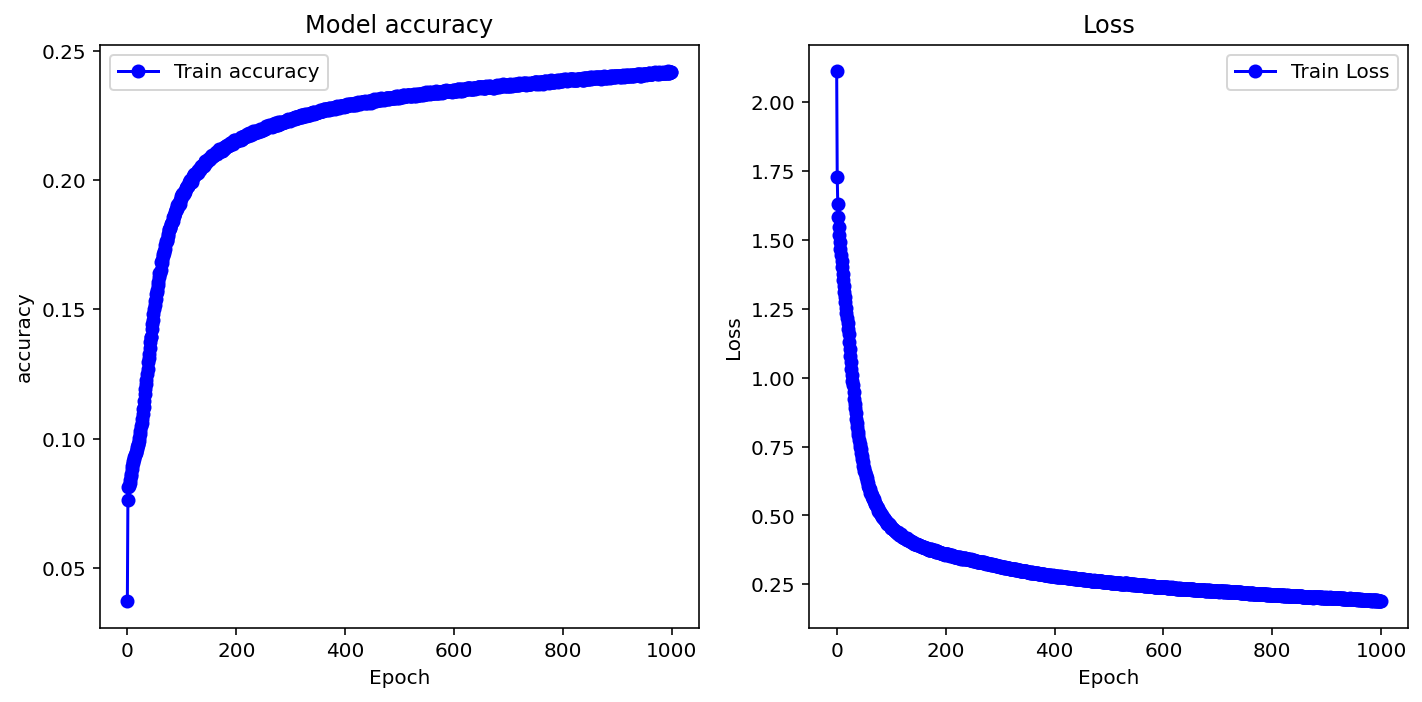

In [38]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))

# 첫 번째 그래프: 정확도 (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy', color='blue', marker='o')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# 두 번째 그래프: 손실 (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Step 5. 모델 평가하기
- Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수

In [39]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [40]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [42]:
sentence_generation('날씨가 좋다.')

입력 : 날씨가 좋다.
출력 : 운전 재미있어요.


'운전 재미있어요.'

In [43]:
sentence_generation('운동이 정말 하기 싫어')

입력 : 운동이 정말 하기 싫어
출력 : 오늘 일찍 주무세요.


'오늘 일찍 주무세요.'

In [44]:
sentence_generation('게임 추천해줘')

입력 : 게임 추천해줘
출력 : 내 집 마련 축하드려요.


'내 집 마련 축하드려요.'

## 회고
- 코드 간격을 수정하다가 오류가 발생을 해서, 수정을 하지 않은채 진행을 하였다.
- 정확도는 높이고 손실값을 줄이기 위해서 많은 epoch로 진행을 했는데 쉽지 않았다.
- 좀 더 깔끔하게 나오려면 전처리가 잘되어야 하는것을 느꼈다.
- 20, 70, 1000 epoch 를 올려가면서 맥락이 아주 조금씩 맞는 대화가 발생을 하기 시작했다. (운동이 정말 하기 싫어 같은 부분)